<div class="alert alert-info">
    <h1>Imports</h1>
    </div>

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import re
import gzip
import shutil
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, recall_score,precision_score,f1_score
from gensim.models.keyedvectors import KeyedVectors
import keras
import tensorflow as tf
from keras import backend
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, Dropout, LSTM, Bidirectional, TimeDistributed, Dense, Flatten
from keras import layers
from keras.layers.merge import concatenate
from keras import preprocessing

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Using TensorFlow backend.


<div class="alert alert-info">
    <h1>Data preparation</h1>
    </div>

In [4]:
# download the data and extract zip files
if('generation-projet-trn.tar.gz' not in os.listdir()):
    ! wget https://sophierosset.github.io/docs/1718/generation-projet-trn.tar.gz
    ! wget https://sophierosset.github.io/docs/1718/generation-projet-dev.tar.gz
    ! wget https://sophierosset.github.io/docs/1718/generation-projet-test.tar.gz

    for file in os.listdir():
        if(file.endswith("tar.gz")):
            tar = tarfile.open(file, "r:gz")
            tar.extractall()
            tar.close()

In [5]:
def get_data(filename):
    """
    This function takes as input a directory name and
    return all the contents of the xml files in a list.
    """
    l = []
    for file in os.listdir(filename):
        if(file.endswith("xml")):
            with open(os.path.join(filename,file)) as f:
                l += f.read().split("\n")
    
    return [el for el in l if len(el) != 0]

In [6]:
train = get_data("generation-projet-trn")
val = get_data("generation-projet-dev")
test = get_data("generation-projet-test")
print("nbre of sentences in training set: {}\nnbre of sentences in \
validation set: {}\nnbre of sentences in testing set: {}"\
      .format(len(train),len(val),len(test)))

nbre of sentences in training set: 2772244
nbre of sentences in validation set: 1839
nbre of sentences in testing set: 2450


In [7]:
tags = set()
l = re.findall('<[^/].*?>',str(train))
for el in l:
    tags.add(el)
    
closed_tags = set()
l = re.findall('</.*?>',str(train))
for el in l:
    closed_tags.add(el)
print("The set of tags in the xml files are: {}".format(tags))

The set of tags in the xml files are: {'<neg_cat-ingredient>', '<recipe>', '<neg_ingredient>', '<cat-ingredient>', '<ingredient>'}


In [8]:
# create dictionaries to map tags to indices and vice versa
tag2index  = {}
index2tag = {}
tag2index['<O>'] = 0
index2tag[0] = '<O>'
for i,tag in enumerate(tags):
    tag2index[tag] = i+1
    index2tag[i+1] = tag

In [9]:
def prepare_data(l):
    """
    This function takes a list of sentences as input and
    return a list of sentences without tags in X and 
    corresponding entity for each word in y.
    """
    X = []
    y = []
    
    for el in l:
        tmp = []
        tmp1 = []
        tag = 0
        
        for w in el.split(" "):
            if(w in tags or w in closed_tags):
                if(w in tags):
                    tag = tag2index[w]
                else:
                    tag = 0
            else:
                tmp.append(w)
                tmp1.append(tag)
        
        X.append(tmp)
        y.append(tmp1)
        
    return X,y

In [10]:
X_train,y_train = prepare_data(train)
X_val,y_val = prepare_data(val)
X_test,y_test = prepare_data(test)

In [11]:
lengths = [len(x) for x in X_train]
print("nombre maximal de mots dans une phrase:{0}\n\
nombre minimal de mots dans une phrase:{1}\n\
nombre moyenne de mots dans une phrase:{2:.1f}\n\
nombre médian de mots dans une phrase :{3}"\
      .format(np.max(lengths),np.min(lengths),np.mean(lengths),np.median(lengths)))

nombre maximal de mots dans une phrase:92
nombre minimal de mots dans une phrase:2
nombre moyenne de mots dans une phrase:8.5
nombre médian de mots dans une phrase :8.0


In [12]:
maxlen = np.max(lengths)
max_words = 50000
embedding_dim = 200

In [13]:
tokenizer = Tokenizer(num_words = max_words)

tokenizer.fit_on_texts(X_train)

sequences = np.array(tokenizer.texts_to_sequences(X_train))

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 10725 unique tokens.


In [14]:
# add zero padding 
X_train = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)
y_train = preprocessing.sequence.pad_sequences(y_train, maxlen=maxlen)

sequences = np.array(tokenizer.texts_to_sequences(X_val))
X_val = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)
y_val = preprocessing.sequence.pad_sequences(y_val, maxlen=maxlen)

sequences = np.array(tokenizer.texts_to_sequences(X_test))
X_test = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)
y_test = preprocessing.sequence.pad_sequences(y_test, maxlen=maxlen)

In [16]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((2772244, 92), (2772244, 92), (2450, 92), (2450, 92), (1839, 92), (1839, 92))

<div class="alert alert-info">
    <h1>Pretrained word embeddings</h1>
    </div>

In [17]:
# output.txt is the name of the file containing the embeddings, 
# if you don't have it just run this cell and everything is done

if('output.txt' not in os.listdir()):
    ! wget http://embeddings.net/frWac_non_lem_no_postag_no_phrase_200_cbow_cut0.bin
    ! git clone https://github.com/marekrei/convertvec
    os.chdir(os.path.join(os.getcwd(),"convertvec"))
    ! make
    ! ./convertvec bin2txt ../frWac_non_lem_no_postag_no_phrase_200_cbow_cut0.bin ../output.txt
    os.chdir("/".join(os.getcwd().split("/")[:-1]))

In [18]:
embeddings_index = {}

with open('output.txt','r',encoding='ISO-8859-1') as f:
    for i,line in enumerate(f):
        if(i != 0):
            values = line.split()
            
            # some words are more than one token, like c'est a dire, so we concatenate all tokens together
            word = "".join([values[i] for i in range(len(values) - 200)])

            coefs = np.asarray(values[len(values) - 200:], dtype='float32')

            embeddings_index[word] = coefs
            

# create a zero embeddings for words that don't appear
# in the vocabulary of the pretrained embeddings
embeddings_index["unk"] = np.zeros(200)
print('Found %s word vectors.' % len(embeddings_index))

Found 2516802 word vectors.


In [19]:
# take max_words as the minimum between our vocab in 
# the training corpus and our initial choice of 50000
max_words = np.min([50000,len(word_index)])

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = embeddings_index.get("unk")

embedding_matrix.shape

(10725, 200)

In [22]:
model = Sequential()
model.add(Embedding(max_words , embedding_dim, weights = [embedding_matrix], input_length=maxlen))
model.add(Bidirectional(LSTM(300, return_sequences=True),merge_mode='ave'))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(300, return_sequences=True),merge_mode='ave'))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(6, activation = 'softmax'), input_shape=(92, 300)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 92, 200)           2145000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 92, 300)           1202400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 92, 300)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 92, 300)           1442400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 92, 300)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 92, 6)             1806      
Total params: 4,791,606
Trainable params: 4,791,606
Non-trainable params: 0
_________________________________________________________________


In [23]:
# one hot encoding
y_train = (np.arange(y_train.max()+1) == y_train[...,None]).astype(int)
y_val = (np.arange(y_val.max()+1) == y_val[...,None]).astype(int)

_If the weights are calculated, just load them. Note that Keras loaded them 
but reinitialized all the parameters randomly, so it doesn't work. 
You can find this issue <a href = "https://github.com/keras-team/keras/issues/4875?fbclid=IwAR3yGYcUTm1tccpM-6iWWGd8ICfxj2qeFHcTUm1TXUjfmjv-SJOA4aL9vKw">here</a>._

In [24]:
if('weights.h5' not in os.listdir()):
    
    model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train,
              batch_size=256,
              epochs=1,
              validation_data=[X_val, y_val])
    
    model.save_weights("weights.h5")

# else:
    
#     model.load_weights("weights.h5")

Train on 2772244 samples, validate on 1839 samples
Epoch 1/1
2772244/2772244 [==============================] - 28598s 10ms/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0842 - val_acc: 0.9927


In [25]:
ypred = model.predict(X_test)

In [26]:
print("accuracy: ",accuracy_score(np.ravel(y_test), np.ravel(np.argmax(ypred,axis=2))))

accuracy:  0.9829503105590062


In [27]:
print("choisir toujours la classe <O>: ",(np.ravel(np.argmax(ypred,axis=2)) == 0).sum()/np.ravel(np.argmax(ypred,axis=2)).shape[0])

choisir toujours la classe <O>:  0.9580479148181011


In [54]:
prec, rec, f1, _ = precision_recall_fscore_support(np.ravel(y_test), \
                                                   np.ravel(np.argmax(ypred,axis=2)),average='macro')
print("precision: {0:.3f}\nrecall: {1:.3f}\nf1 score: {2:.3f}".format(prec,rec,f1))

precision: 0.418
recall: 0.430
f1 score: 0.417


In [58]:
prec, rec, f1

(0.4177392754248133, 0.4304269755119006, 0.41703146657818246)

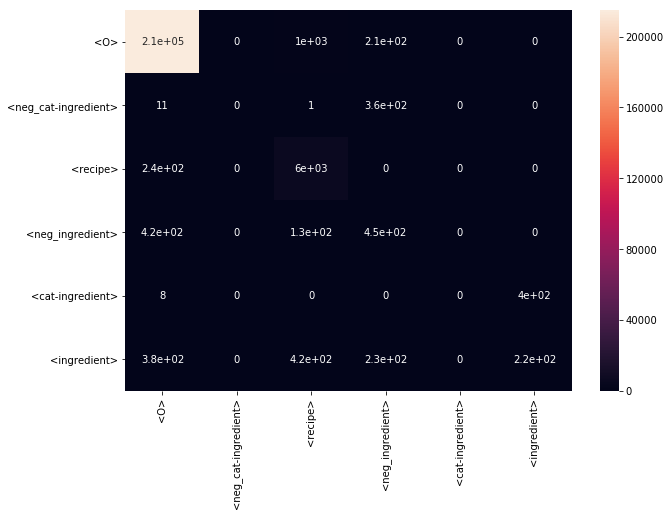

In [31]:
conf = confusion_matrix(np.ravel(y_test), np.ravel(np.argmax(ypred,axis=2)),labels=[0,1,2,3,4,5])
df_cm = pd.DataFrame(conf, index = [index2tag[i] for i in np.arange(6)],
                  columns = [index2tag[i] for i in np.arange(6)])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.show()

In [55]:
def SER(y_pred,y_test): 
    return (1-f1_score(y_test,y_pred,average="macro"))*1.5

In [169]:
print("SER : %s"%SER(np.ravel(y_test), np.ravel(np.argmax(ypred,axis=2))))

SER : 0.8744528001327263


<div class="alert alert-info">
    <h1>Interpretation</h1>
    </div>

In [182]:
# the indices of true and false predicted sentences
true_index = [i for i in range(y_test.shape[0]) if np.all(y_test[i] == np.argmax(ypred,axis=2)[i])]
false_index = [i for i in range(y_test.shape[0]) if np.any(y_test[i] != np.argmax(ypred,axis=2)[i])]

_There is a data leakage? Not really_

In [168]:
print("These sentences exist in the training set")
for i in np.array(test)[true_index]:
    if(i in train):
        print(i)

These sentences exist in the training set
pas de <neg_ingredient> raifort </neg_ingredient> , juste des <ingredient> lamproie </ingredient>
pas de <neg_ingredient> melon </neg_ingredient> , juste des <ingredient> lamproie </ingredient>
pas de <neg_ingredient> anguille </neg_ingredient> , juste des <ingredient> bergamote </ingredient>
pouvez-vous me donner la recette de <recipe> noix de saint jacques au pastis </recipe> ?


In [215]:
# unique (words between the tags) that are falsely predicted
mots_false = np.unique([re.findall('<.*> (.*?) </.*>',i) for i in np.array(test)[false_index]])

In [230]:
# unique (words between the tags) that are correctly predicted
mots_true = np.unique([re.findall('<.*> (.*?) </.*>',i) for i in np.array(test)[true_index]])

In [235]:
# words that exist in correctly predicted sentences and in the falsely predicted
mot_exist = []
for mot in mots_true:
    if(len([i for i in np.array(test)[false_index] if re.match(".*"+mot+".*",i)]) != 0):
        mot_exist.append(mot)

In [304]:
# a dictionary that contains sentences of words that are sometimes correctly predicted sometimes not
# test is the list of test sentences
dico = {}
for i in test:
    for mot in mot_exist:
        if(re.match(".*"+mot+".*",i)):
            if(mot in dico.keys()):
                dico[mot] +=  "\n" +str(i in np.array(test)[true_index])+": "+i
            else:
                dico[mot]  = str(i in np.array(test)[true_index])+": "+i

In [305]:
dico.keys()

dict_keys(['ami de chambertin', 'hareng', 'ortie', 'piment', 'dolique lablab', 'pose', 'saint andrews', 'emmental', 'bouquet des moines', 'sandre', 'oseille', 'pomme de cajou', 'mahaleb', 'capelan', 'amande', 'dashi', 'côte de porc', 'noix de muscade', 'curé nantais', 'empereur gueule longue', 'escalope de poulet', 'kipper', 'fenouil', 'maïs doux', 'mérou oualioua', 'Manicotti', 'romaine', 'tyrolien', 'cantal', 'lamproie', 'white stilton', 'pavot', 'houmous', 'grogneur', 'moutarde', 'bergamote', 'Rigatoni', 'allgäuer bergkäse', 'lys asiatique comestible', 'paladin', 'las bardenas', 'polkobin', 'bosworth', 'bokrijk', 'villalon', 'wilstermarsch', 'old sarum', 'combava', 'oustet', 'chili', 'olive', 'elgar', 'abricot', 'ananas', 'homard', 'ossolano', 'caviar', 'quiche aux oignons confits', 'tomme de brebis', 'blue dorset vinney', 'lotte au riesling et epinards', 'aubergines farcies aux legumes ou mixte', 'salade d automne rapide', 'filet de colin au pesto', 'tarte aux fraises', 'tarte aux 

In [310]:
# like this we can compare each set of sentences that contains words sometimes correctly predicted
# True means correctly predicted and false not.
dico['ami de chambertin'].split("\n")

["True: j'aime pas l' <neg_ingredient> ami de chambertin </neg_ingredient>",
 "False: d' <ingredient> ami de chambertin </ingredient>",
 'False: dis-moi je voudrais faire une <recipe> quiche aux oignons confits </recipe> mais sans <neg_ingredient> ami de chambertin </neg_ingredient>',
 "False: donne-moi une recette de <recipe> patates douces au citron vert et romarin </recipe> avec d' <ingredient> ami de chambertin </ingredient>",
 "False: est-ce que tu peux me dire par quoi remplacer l' <ingredient> ami de chambertin </ingredient> dans la <recipe> quiche aux poireaux et fromage blanc </recipe> ?"]

In [309]:
# check if all sentence that begin with d' or de aren't correctly predicted
# length of the lists that contain sentences begin with "de" are 0, same for d'

print(len([i for i in train if i.startswith("de")]),\
      len([i for i in np.array(test)[true_index] if i.startswith("de")]))

0 0
